In [13]:
# =============================================================================
# Carico i file
# =============================================================================
train_file = r'data/training.txt'
train_url=r'data/training1.csv'
test_file = r'data/test.txt'
test_url = r'data/test1.csv'
delimiter = ','

import pandas as pd
df = pd.read_csv(r'data/training1.csv')

import csv
x_train = list()
y_train = list()
topic_train = list()
with open(train_url, encoding='utf-8', newline='') as infile:
    reader = csv.reader(infile, delimiter=delimiter)
    for row in reader:
        x_train.append(row[5])
        y_train.append(row[4])
        topic_train.append(row[3])

x_test = list()
y_test = list()
topic_test = list()
with open(test_url, encoding='utf-8', newline='') as infile:
    reader = csv.reader(infile, delimiter=delimiter)
    for row in reader:
        x_test.append(row[5])
        y_test.append(row[4])
        topic_test.append(row[3])
        
len(x_train),len(y_train),len(x_test),len(y_test)
y_train.pop(0) # elimino il primo elemento che è la parola "gender"
y_test.pop(0) # elimino il primo elemento che è la parola "gender"
set(y_train)
sample_idx = 10

x_train.pop(0) # elimino il primo elemento che è la parola "post"
x_test.pop(0) # elimino il primo elemento che è la parola "post"
x_train[sample_idx]
y_train[sample_idx]

topic_train.pop(0) # elimino il primo elemento che è "topic"
topic_test.pop(0) # elimino il primo elemento che è "topic"

# =============================================================================
# Campiono i dati per rimediare allo sbilanciamento di questi
# =============================================================================
"""
df_train = pd.DataFrame(data = {"x": x_train, "y": y_train})
#df_test = pd.DataFrame(data = {"x": x_test, "y": y_test})

# Training Set
df_train = df_train.groupby('y', group_keys=False).apply(lambda x: x.sample(min(len(x), 125)))
df_train["y"].tolist().count("M")

x_train = df_train["x"].tolist()
y_train = df_train["y"].tolist()
"""
# =============================================================================
# Seleziono il topic       commentare questa parte per prendere tutti topic
# =============================================================================


topics = df["topic"].unique()
print(topics)
from collections import Counter
Counter(df["topic"])
# Seleziono il training set
indices = [i for i, x in enumerate(topic_train) if x == "CELEBRITIES"]
x_train = [x_train[i] for i in indices]
y_train = [y_train[i] for i in indices]
# len(x_train), len(y_train)
print("Lunghezza del training set: ", len(x_train))
print("Percentuale di maschi nel training set: ", round(y_train.count("M") / len(y_train), 3))

# Seleziono il test set
indices = [i for i, x in enumerate(topic_test) if x == "CELEBRITIES"]
x_test = [x_test[i] for i in indices]
y_test = [y_test[i] for i in indices]
# len(x_test), len(y_test)
print("Lunghezza del test set: ", len(x_test))
print("Percentuale di maschi nel test set: ", round(y_test.count("M") / len(y_test), 3))


# =============================================================================
# Operazioni sul testo
# =============================================================================
# Rendo minuscola la prima parola dopo il punto
import string
import re

# Elimino la parola "post"
regex = re.compile("\\bpost\\b")
for i in range(0, len(x_train)):
    x_train[i] = regex.sub('', x_train[i])
for i in range(0, len(x_test)):
    x_test[i] = regex.sub('', x_test[i])
# Elimino la punteggiatura
regex = re.compile('[%s]' % re.escape(string.punctuation))
for i in range(0, len(x_train)):
    x_train[i] = regex.sub('', x_train[i])
for i in range(0, len(x_test)):
    x_test[i] = regex.sub('', x_test[i])
# Elimino i numeri
regex = re.compile("[0-9]+")
for i in range(0, len(x_train)):
    x_train[i] = regex.sub('', x_train[i])
for i in range(0, len(x_test)):
    x_test[i] = regex.sub('', x_test[i])

### EXTRA: NON IMPORTANTE
# Rendo minuscola la prima parola dopo il punto
# for i in range(0, len(x_train)):
    # x_train[i] = re.sub('(?<=\.\s)(\w+)', lambda m: m.group().lower(), x_train[i])
# for i in range(0, len(x_test)):
    # x_test[i] = re.sub('(?<=\.\s)(\w+)', lambda m: m.group().lower(), x_test[i])
# Rendo minuscola la prima parola
# for i in range(0, len(x_train)):
    # x_train[i] = x_train[i][1].lower() + x_train[i][2:] # il primo carattere di ogni post è \n, quindi parto da 1, non da 0
# for i in range(0, len(x_test)):
    # x_test[i] = x_test[i][1].lower() + x_test[i][2:] # il primo carattere di ogni post è \n, quindi parto da 1, non da 0
###

# =============================================================================
# Funzioni
# =============================================================================
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize, pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

stopword_list = stopwords.words('italian')

from collections import defaultdict
tag_map = defaultdict(lambda : wordnet.NOUN)
tag_map['J'] = wordnet.ADJ
tag_map['V'] = wordnet.VERB
tag_map['R'] = wordnet.ADV
lemmatizer = WordNetLemmatizer()

doc_counter = 0
def reset_counter():
    global doc_counter
    doc_counter = 0

def increase_counter():
    global doc_counter
    doc_counter += 1
    if doc_counter % 100 == 0:
        print(doc_counter)

def nltk_ngram_tokenizer(text):
    increase_counter()

    # tokens, skipping stopwords
    tokens = [token for token in word_tokenize(text) if token not in stopword_list]

    # we use a simple nltk function to create ngrams
    bigrams = ['BI_'+w1+'_'+w2 for w1,w2 in nltk.ngrams(tokens,2)]
    trigrams = ['TRI_'+p1+'_'+p2+'_'+p3 for p1,p2,p3 in nltk.ngrams(tokens,3)]

    all_tokens = list()
    all_tokens.extend(tokens)
    all_tokens.extend(bigrams)
    all_tokens.extend(trigrams)
    return all_tokens

def nltk_nlp_tokenizer(text):
    increase_counter()

    # tokens, skipping stopwords
    tokens = [token for token in word_tokenize(text) if token not in stopword_list]

    # lemmatized tokens
    lemmas = list()
    for token, tag in pos_tag(tokens):
  	    lemmas.append('LEMMA_'+lemmatizer.lemmatize(token, tag_map[tag[0]]))

    # we use a simple nltk function to create ngrams
    lemma_bigrams = ['BI_'+p1+'_'+p2 for p1,p2 in nltk.ngrams(lemmas,2)]
    lemma_trigrams = ['TRI_'+p1+'_'+p2+'_'+p3 for p1,p2,p3 in nltk.ngrams(lemmas,3)]

    all_tokens = list()
    all_tokens.extend(lemmas)
    all_tokens.extend(lemma_bigrams)
    all_tokens.extend(lemma_trigrams)
    return all_tokens

import spacy
import re
nlp = spacy.load('it_core_news_sm')

def spacy_nlp_tokenizer(text):
    increase_counter()

    # substituting all space characters with a single space
    text = re.sub('\s+', ' ', text)

    # we use spacy for main nlp tasks
    doc = nlp(text)
    # lemmatized tokens, skipping stopwords
    lemmas = ['LEMMA_'+token.lemma_ for token in doc if not token.is_stop]
    # entity_types
    entity_types = ['NER_'+token.ent_type_ for token in doc if token.ent_type_]

    
    # we use a simple nltk function to create ngrams
    lemma_bigrams = ['BI_'+p1+'_'+p2 for p1,p2 in nltk.ngrams(lemmas,2)]
    lemma_trigrams = ['TRI_'+p1+'_'+p2+'_'+p3 for p1,p2,p3 in nltk.ngrams(lemmas,3)]

    all_tokens = list()
    all_tokens.extend(lemmas)
    all_tokens.extend(lemma_bigrams)
    all_tokens.extend(lemma_trigrams)
    all_tokens.extend(entity_types)
    return all_tokens

# Rendo la risposta binaria
import numpy as np
# y_train[sample_idx] è una delle due classi, nel nostro caso M. Quando vado a fare y_train == y_train[sample_idx], in pratica
# metto TRUE per i maschi (M) e FALSE per le femmine (F).
y_train_bin = np.asarray(y_train)==y_train[sample_idx]
y_test_bin = np.asarray(y_test)==y_train[sample_idx]
y_train_bin,y_test_bin

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
vect = CountVectorizer(analyzer = nltk_nlp_tokenizer, min_df=5) # Passiamo la funzione spacy_nlp_tokenizer per ottenere sia parole singole che n-grams
reset_counter()
X_train_tok = vect.fit_transform(x_train)
reset_counter()
X_test_tok = vect.transform(x_test)

len(vect.vocabulary_)
X_train_tok[:5]
print(X_train_tok[:5])
vect.inverse_transform(X_train_tok[:5])
for feat,freq in zip(vect.inverse_transform(X_train_tok[:5])[1],X_train_tok[:5].data):
  print(feat,freq)

# FEATURE SELECTION
bin_sel = SelectKBest(chi2, k=150)
bin_sel.fit(X_train_tok,y_train_bin)
X_train_sel_bin = bin_sel.transform(X_train_tok)
X_test_sel_bin = bin_sel.transform(X_test_tok)

bin_sel.get_support()
X_train_sel_bin
print("Features")
print(X_train_sel_bin[:5])
print(vect.inverse_transform(bin_sel.inverse_transform(X_train_sel_bin[:5])))

# PESI CON TF-IDF
tfidf = TfidfTransformer()
tfidf.fit(X_train_sel_bin)
X_train_vec_bin = tfidf.transform(X_train_sel_bin)
X_test_vec_bin =tfidf.transform(X_test_sel_bin)
print("Pesi Tf-IdF")
print(X_train_vec_bin[:5])
for feat,weight,freq in zip(vect.inverse_transform(bin_sel.inverse_transform(X_train_vec_bin[:5]))[1],X_train_vec_bin[:5].data,X_train_sel_bin[:5].data):
  print(feat,weight,freq)


# =============================================================================
# Support Vector Machine ma con la Pipeline
# =============================================================================
bin_pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k=150)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

reset_counter()
bin_pipeline.fit(X_train_tok,y_train_bin)

# ACCURACY
reset_counter()
bin_predictions = bin_pipeline.predict(X_test_tok)
correct = 0
for prediction,true_label in zip(bin_predictions, y_test_bin):
    if prediction==true_label:
        correct += 1
print("Accuracy:", correct/len(bin_predictions))

# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
print('Classification report del LinearSVC con la pipeline:')
print(classification_report(y_test_bin, bin_predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test_bin, bin_predictions)
print(cm)

tokenizer = vect
selector = bin_pipeline.named_steps['sel']
classifier = bin_pipeline.named_steps['learner']

feature_names = tokenizer.get_feature_names()
feats_w_score = list()
for index,(selected,score) in enumerate(zip(selector.get_support(),selector.scores_)):
    feats_w_score.append((score,selected,feature_names[index]))
feats_w_score = sorted(feats_w_score)
len(feats_w_score)

feats_w_score[:100],feats_w_score[-100:]
feats_w_classifier_weight = list()
for index,weight in enumerate(selector.inverse_transform(classifier.coef_)[0]):
    if weight!=0:
        feats_w_classifier_weight.append((weight,feature_names[index]))
feats_w_classifier_weight = sorted(feats_w_classifier_weight)
len(feats_w_classifier_weight)

feats_w_classifier_weight[-100:]
feats_w_classifier_weight[:100]

# =============================================================================
# Decision Tree
# =============================================================================
dt_bin_pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k=150)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', DecisionTreeClassifier())  # learning algorithm
])

dt_bin_pipeline.fit(X_train_tok,y_train_bin)
bin_predictions = dt_bin_pipeline.predict(X_test_tok)

print('Classification report del Decision Tree:')
print(classification_report(y_test_bin, bin_predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test_bin, bin_predictions)
print(cm)
# =============================================================================
# Decision Tree visualizzazione 
# =============================================================================
"""
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(24, 24))
plot_tree(dt_bin_pipeline.named_steps['learner'])
plt.show()
"""
# =============================================================================
# Multinomial NB
# =============================================================================
nb_bin_pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k=150)),  # feature selection
    ('learner', MultinomialNB())  # learning algorithm
])

nb_bin_pipeline.fit(X_train_tok,y_train_bin)
bin_predictions = nb_bin_pipeline.predict(X_test_tok)

print('Classification report del MultinomialNB:')
print(classification_report(y_test_bin, bin_predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test_bin, bin_predictions)
print(cm)


tokenizer = vect
selector = nb_bin_pipeline.named_steps['sel']
classifier = nb_bin_pipeline.named_steps['learner']
classifier.class_log_prior_,classifier.feature_log_prob_, len(classifier.feature_log_prob_[0])
ratio = classifier.feature_log_prob_[0]/classifier.feature_log_prob_[1]

feats_w_classifier_weight = list()
feature_names = tokenizer.get_feature_names()
for index,weight in enumerate(selector.inverse_transform([ratio])[0]):
    if weight!=0:
        feats_w_classifier_weight.append((weight,feature_names[index]))
feats_w_classifier_weight = sorted(feats_w_classifier_weight)
len(feats_w_classifier_weight)

feats_w_classifier_weight[-100::-1]
feats_w_classifier_weight[:100]


# =============================================================================
# Logistic Regression 
# =============================================================================
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k=150)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LogisticRegression(solver="liblinear",multi_class="auto"))  # learning algorithm
])

classifier = pipeline.fit(X_train_tok,y_train_bin)
predictions = classifier.predict(X_test_tok)


from sklearn.metrics import confusion_matrix, classification_report
print('Classification report della Logistic Regression:')
print(classification_report(y_test_bin, bin_predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test_bin, bin_predictions)
print(cm)




['ANIME' 'BIKES' 'SPORTS' 'AUTO-MOTO' 'NATURE' 'METAL-DETECTING'
 'MEDICINE-AESTHETICS' 'CELEBRITIES' 'SMOKE' 'ENTERTAINMENT' 'TECHNOLOGY']
Lunghezza del training set:  42
Percentuale di maschi nel training set:  0.452
Lunghezza del test set:  7
Percentuale di maschi nel test set:  0.571
  (0, 29)	1
  (0, 31)	2
  (0, 26)	1
  (0, 170)	1
  (0, 254)	1
  (0, 257)	1
  (0, 281)	1
  (0, 162)	3
  (0, 22)	1
  (0, 245)	2
  (0, 190)	1
  (0, 314)	3
  (0, 103)	1
  (0, 181)	1
  (0, 209)	2
  (0, 296)	1
  (0, 297)	2
  (0, 350)	4
  (0, 205)	2
  (0, 3)	1
  (0, 229)	3
  (0, 308)	4
  (0, 299)	3
  (0, 340)	1
  (0, 183)	1
  :	:
  (4, 34)	3
  (4, 49)	1
  (4, 327)	1
  (4, 125)	1
  (4, 287)	1
  (4, 61)	1
  (4, 126)	1
  (4, 133)	1
  (4, 203)	2
  (4, 244)	1
  (4, 62)	2
  (4, 74)	1
  (4, 351)	1
  (4, 241)	1
  (4, 134)	1
  (4, 230)	1
  (4, 129)	1
  (4, 197)	1
  (4, 323)	1
  (4, 16)	1
  (4, 178)	1
  (4, 267)	1
  (4, 136)	1
  (4, 193)	1
  (4, 104)	1
LEMMA_Ho 1
LEMMA_preferito 2
LEMMA_poi 1
LEMMA_magari 1
LEMMA_solo 

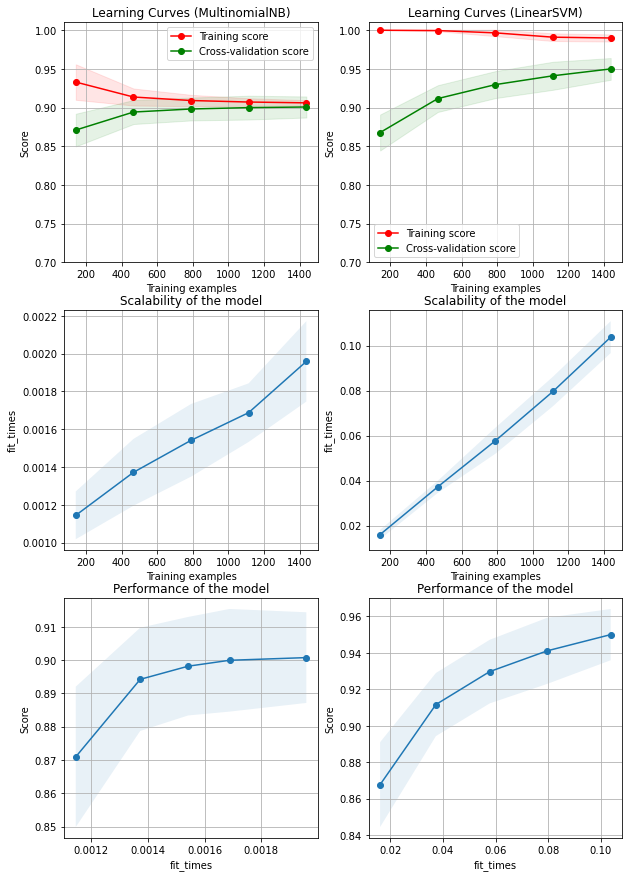

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
   

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = load_digits(return_X_y=True)

title = "Learning Curves (MultinomialNB)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = MultinomialNB()
plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = r"Learning Curves (LinearSVM)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = LinearSVC()
plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.show()